<a href="https://colab.research.google.com/github/Nadiam75/DeepLearning_HW_3/blob/main/DL_Project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import cv2
import math
import h5py
import torch
import PIL
import imghdr
import random
import scipy.io
import colorsys
import argparse
import scipy.misc
%matplotlib inline
import numpy as np
import pandas as pd
import torch.nn as nn
import tensorflow as tf
from functools import reduce
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision import transforms
from matplotlib.pyplot import imshow
from tensorflow.keras import backend as K
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageFont, ImageDraw, Image
from tensorflow.keras.models import load_model
from tensorflow.python.framework.ops import EagerTensor


In [5]:
dataset_path = 'drive/MyDrive/nyu_depth_v2_labeled.mat'

In [6]:
import h5py
f = h5py.File(dataset_path,'r')
depths = f.get('depths')
depths = np.array(depths)
depths= np.transpose(depths, (0,2,1))

In [7]:
images = f.get('images')
images = np.array(images) 
images= np.transpose(images, (0,3,2,1))

#Functions

In [72]:
def DEPTH_Calc_masked(xmin,ymin,xmax,ymax , winnerValue):
  xmin = math.floor(xmin)
  ymin = math.floor(ymin)
  xmax = math.floor(xmax)
  ymax = math.floor(ymax)
  sum = 0
  num = 1
  counter = 0
  for i in range(xmin,xmax +1):
    for j in range(ymin,ymax +1):
      # print( masked_image[j , i])
      # print(winnerValue)
      # print("&&&&&&&&&&&&&&&&&&&")
      if np.array_equal (masked_image[j , i] , winnerValue):

        counter+=1
        sum += pred[j,i]
  # num = (xmax-xmin+1)*(ymax-ymin+1)
  if counter == 0 :
    print("no pixels")
    return DEPTH_Calc(xmin,ymin,xmax,ymax )
  DEPTH = sum/counter
  return DEPTH

In [10]:
def DEPTH_Calc(xmin,ymin,xmax,ymax):
  xmin = math.floor(xmin)
  ymin = math.floor(ymin)
  xmax = math.floor(xmax)
  ymax = math.floor(ymax)
  sum = 0
  num = 1
  for i in range(xmin,xmax +1):
    for j in range(ymin,ymax +1):
      sum += pred[j,i]
  num = (xmax-xmin+1)*(ymax-ymin+1)
  DEPTH = sum/num
  return DEPTH

In [11]:
def preprocess_image(img_path, model_image_size):
    image_type = imghdr.what(img_path)
    image = Image.open(img_path)
    resized_image = image.resize(tuple(reversed(model_image_size)), Image.BICUBIC)
    image_data = np.array(resized_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
    return image, image_data

def compose(*funcs):
    """Compose arbitrarily many functions, evaluated left to right.

    Reference: https://mathieularose.com/function-composition-in-python/
    """
    # return lambda x: reduce(lambda v, f: f(v), funcs, x)
    if funcs:
        return reduce(lambda f, g: lambda *a, **kw: g(f(*a, **kw)), funcs)
    else:
        raise ValueError('Composition of empty sequence not supported.')

def read_classes(classes_path):
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def read_anchors(anchors_path):
    with open(anchors_path) as f:
        anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        anchors = np.array(anchors).reshape(-1, 2)
    return anchors

def scale_boxes(boxes, image_shape):
    """ Scales the predicted boxes in order to be drawable on the image"""
    height = float(image_shape[0])
    width = float(image_shape[1])
    image_dims = K.stack([height, width, height, width])
    image_dims = K.reshape(image_dims, [1, 4])
    boxes = boxes * image_dims
    return boxes

def get_colors_for_classes(num_classes):
    """Return list of random colors for number of classes given."""
    # Use previously generated colors if num_classes is the same.
    if (hasattr(get_colors_for_classes, "colors") and
            len(get_colors_for_classes.colors) == num_classes):
        return get_colors_for_classes.colors

    hsv_tuples = [(x / num_classes, 1., 1.) for x in range(num_classes)]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(
        map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
            colors))
    random.seed(10101)  # Fixed seed for consistent colors across runs.
    random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    random.seed(None)  # Reset seed to default.
    get_colors_for_classes.colors = colors  # Save colors for future calls.
    return colors


def draw_boxes(image, boxes, box_classes, class_names, scores=None, Depth=None):
    """Draw bounding boxes on image.

    Draw bounding boxes with class name and optional box score on image.

    Args:
        image: An `array` of shape (width, height, 3) with values in [0, 1].
        boxes: An `array` of shape (num_boxes, 4) containing box corners as
            (y_min, x_min, y_max, x_max).
        box_classes: A `list` of indicies into `class_names`.
        class_names: A `list` of `string` class names.
        `scores`: A `list` of scores for each box.

    Returns:
        A copy of `image` modified with given bounding boxes.
    """
    #image = Image.fromarray(np.floor(image * 255 + 0.5).astype('uint8'))

    font = ImageFont.truetype(
        font='/content/drive/MyDrive/DL_Project/font/FiraMono-Medium.otf',
        size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    thickness = (image.size[0] + image.size[1]) // 300

    colors = get_colors_for_classes(len(class_names))

    for i, c in list(enumerate(box_classes)):
        box_class = class_names[c]
        box = boxes[i]
        
        if isinstance(scores.numpy(), np.ndarray):
            score = scores.numpy()[i]
            depth = Depth[i]
            label = '{} {:.2f}| ({}m)'.format(box_class, score,depth)
        else:
            label = '{}'.format(box_class)

        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)

        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
        # print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        # My kingdom for a good redistributable image drawing library.
        for i in range(thickness):
            draw.rectangle(
                [left + i, top + i, right - i, bottom - i], outline=colors[c])
        draw.rectangle(
            [tuple(text_origin), tuple(text_origin + label_size)],
            fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw

    return np.array(image)

In [12]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 conv layer with padding."""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


def get_incoming_shape(incoming):
    size = incoming.size()
    # returns the incoming data shape as a list
    return [size[0], size[1], size[2], size[3]]


def interleave(tensors, axis):
    # change the first element (batch_size to -1)
    old_shape = get_incoming_shape(tensors[0])[1:]
    new_shape = [-1] + old_shape

    # double 1 dimension
    new_shape[axis] *= len(tensors)

    # pack the tensors on top of each other
    stacked = torch.stack(tensors, axis+1)

    # reshape and return
    reshaped = stacked.view(new_shape)
    return reshaped


class UnpoolingAsConvolution(nn.Module):
    def __init__(self, inplanes, planes):
        super(UnpoolingAsConvolution, self).__init__()

        # interleaving convolutions
        self.conv_A = nn.Conv2d(in_channels=inplanes, out_channels=planes, kernel_size=(3, 3), stride=1, padding=1)
        self.conv_B = nn.Conv2d(in_channels=inplanes, out_channels=planes, kernel_size=(2, 3), stride=1, padding=0)
        self.conv_C = nn.Conv2d(in_channels=inplanes, out_channels=planes, kernel_size=(3, 2), stride=1, padding=0)
        self.conv_D = nn.Conv2d(in_channels=inplanes, out_channels=planes, kernel_size=(2, 2), stride=1, padding=0)

    def forward(self, x):
        output_a = self.conv_A(x)

        padded_b = nn.functional.pad(x, (1, 1, 0, 1))
        output_b = self.conv_B(padded_b)

        padded_c = nn.functional.pad(x, (0, 1, 1, 1))
        output_c = self.conv_C(padded_c)

        padded_d = nn.functional.pad(x, (0, 1, 0, 1))
        output_d = self.conv_D(padded_d)

        left = interleave([output_a, output_b], axis=2)
        right = interleave([output_c, output_d], axis=2)
        y = interleave([left, right], axis=3)
        return y


class UpProjection(nn.Module):
    def __init__(self, inplanes, planes):
        super(UpProjection, self).__init__()

        self.unpool_main = UnpoolingAsConvolution(inplanes, planes)
        self.unpool_res = UnpoolingAsConvolution(inplanes, planes)

        self.main_branch = nn.Sequential(
            self.unpool_main,
            nn.BatchNorm2d(planes),
            nn.ReLU(inplace=False),
            nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(planes)
        )

        self.residual_branch = nn.Sequential(
            self.unpool_res,
            nn.BatchNorm2d(planes),
        )

        self.relu = nn.ReLU(inplace=False)

    def forward(self, input_data):
        x = self.main_branch(input_data)
        res = self.residual_branch(input_data)
        x += res
        x = self.relu(x)
        return x


class ConConv(nn.Module):
    def __init__(self, inplanes_x1, inplanes_x2, planes):
        super(ConConv, self).__init__()
        self.conv = nn.Conv2d(inplanes_x1 + inplanes_x2, planes, kernel_size=1, bias=True)

    def forward(self, x1, x2):
        x1 = torch.cat([x2, x1], dim=1)
        x1 = self.conv(x1)
        return x1


class ResnetUnetHybrid(nn.Module):
    def __init__(self, block, layers):
        self.inplanes = 64

        # resnet layers
        super(ResnetUnetHybrid, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # additional up projection layers parts
        self.conv2 = nn.Conv2d(2048, 1024, 1, bias=True)
        self.bn2 = nn.BatchNorm2d(1024)

        self.up_proj1 = UpProjection(1024, 512)
        self.up_proj2 = UpProjection(512, 256)
        self.up_proj3 = UpProjection(256, 128)
        self.up_proj4 = UpProjection(128, 64)

        self.drop = nn.Dropout(0.5, False)
        self.conv3 = nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1, bias=True)

        # padding + concat for unet stuff
        self.con_conv1 = ConConv(1024, 512, 512)
        self.con_conv2 = ConConv(512, 256, 256)
        self.con_conv3 = ConConv(256, 128, 128)
        self.con_conv4 = ConConv(64, 64, 64)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, 0, 0.01)

            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = list()
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x_to_conv4 = self.relu(x)

        x = self.maxpool(x_to_conv4)
        x_to_conv3 = self.layer1(x)
        x_to_conv2 = self.layer2(x_to_conv3)
        x_to_conv1 = self.layer3(x_to_conv2)
        x = self.layer4(x_to_conv1)

        # additional layers
        x = self.conv2(x)
        x = self.bn2(x)

        # up project part
        x = self.up_proj1(x)
        x = self.con_conv1(x, x_to_conv1)

        x = self.up_proj2(x)
        x = self.con_conv2(x, x_to_conv2)

        x = self.up_proj3(x)
        x = self.con_conv3(x, x_to_conv3)

        x = self.up_proj4(x)
        x = self.con_conv4(x, x_to_conv4)

        x = self.drop(x)
        x = self.conv3(x)
        x = self.relu(x)

        return x

    @classmethod
    def load_pretrained(cls, device, load_path='hyb_net_weights.model'):
        model = cls(Bottleneck, [3, 4, 6, 3])

        # download the weights if they are not present
        if not os.path.exists(load_path):
            print('Downloading model weights...')
            os.system('wget https://www.dropbox.com/s/amad4ko9opi4kts/hyb_net_weights.model')

        model = model.to(device)
        model.load_state_dict(torch.load(load_path, map_location=device))

        return model


In [13]:
def DEPTH_Calc(xmin,ymin,xmax,ymax):
  xmin = math.floor(xmin)
  ymin = math.floor(ymin)
  xmax = math.floor(xmax)
  ymax = math.floor(ymax)
  sum = 0
  num = 1
  for i in range(xmin,xmax +1):
    for j in range(ymin,ymax +1):
      sum += pred[j,i]
  num = (xmax-xmin+1)*(ymax-ymin+1)
  DEPTH = sum/num
  return DEPTH

In [14]:
HEIGHT = 256
WIDTH = 320


def scale_image(img, scale=None):
    """Resize/scale an image. If a scale is not provided, scale it closer to HEIGHT x WIDTH."""
    # if scale is None, scale to the longer size
    if scale is None:
        scale = max(WIDTH / img.shape[1], HEIGHT / img.shape[0])

    new_size = (math.ceil(img.shape[1] * scale), math.ceil(img.shape[0] * scale))
    image = cv2.resize(img, new_size, interpolation=cv2.INTER_NEAREST)
    return image


def center_crop(img):
    """Center crop an image to HEIGHT x WIDTH."""
    corner = ((img.shape[0] - HEIGHT) // 2, (img.shape[1] - WIDTH) // 2)
    img = img[corner[0]:corner[0] + HEIGHT, corner[1]:corner[1] + WIDTH]
    return img


def img_transform(img):
    """Normalize an image."""
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img = data_transform(img)
    return img


def show_img_and_pred(img, depth):
    """Plot an image and a corresponding prediction next to each other."""
    plt.figure(figsize = (12 ,6))
    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    pred = np.transpose(depth, (1, 2, 0))
    pred = pred [ : , : , 0]
    plt.imshow(pred ,  cmap=plt.cm.gist_rainbow)

    plt.show()
    


def depth_to_grayscale(depth, max_dist=10.0):
    """Transform a prediction into a grayscale 8-bit image."""
    depth = np.transpose(depth, (1, 2, 0))
    depth[depth > max_dist] = max_dist
    depth = depth / max_dist

    depth = np.array(depth * 255.0, dtype=np.uint8)
    depth = cv2.resize(depth, (WIDTH, HEIGHT))

    bgr_depth_img = cv2.cvtColor(depth, cv2.COLOR_GRAY2BGR)
    bgr_depth_img = np.clip(bgr_depth_img, 0, 255)
    return bgr_depth_img


In [15]:
def predict_img(img):
    """Inference a single image."""
    # switch to CUDA device if possible
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('Use GPU: {}'.format(str(device) != 'cpu'))

    # load model
    print('Loading model...')
    model = ResnetUnetHybrid.load_pretrained(device=device)
    model.eval()

    H = img.shape[1]
    W = img.shape[0]
    img = scale_image(img)
    img = center_crop(img)
    inp = img_transform(img)
    inp = inp[None, :, :, :].to(device)

    # inference
    print('Running the image through the network...')
    output_ = model(inp)

    # transform and plot the results
    output = output_.cpu()[0].data.numpy()
    show_img_and_pred(img, output)

    resized_image = cv2.resize(output[0], ( H , W) , interpolation=cv2.INTER_NEAREST)

    return img , resized_image

#Examples

Use GPU: False
Loading model...
Running the image through the network...


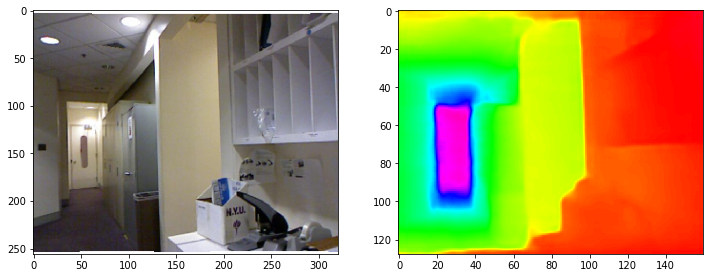

In [16]:
_,depthMap = predict_img(images[11] )

Use GPU: False
Loading model...
Running the image through the network...


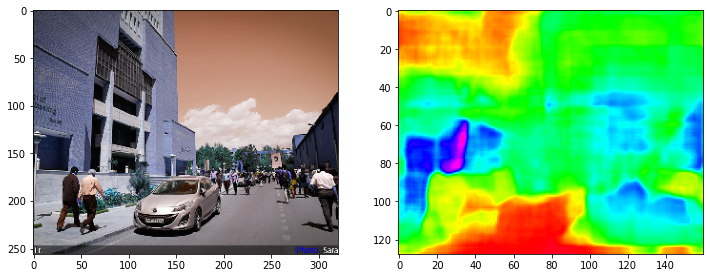

In [17]:
a = cv2.imread('/content/drive/MyDrive/DL_Project/in_images/SHARIF.jpg')
orig , pred = predict_img(a)

In [18]:
model_OD = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5m, yolov5l, yolov5x, custom

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2022-2-1 torch 1.10.0+cu111 CPU



  0%|          | 0.00/14.0M [00:00<?, ?B/s]

Fusing layers... 


Model Summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [19]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install
from yolov5 import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 2022-2-1 torch 1.10.0+cu111 CPU


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 44.3/107.7 GB disk)


/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
Saved 1 image to /content/drive/MyDrive


Use GPU: False
Loading model...
Running the image through the network...


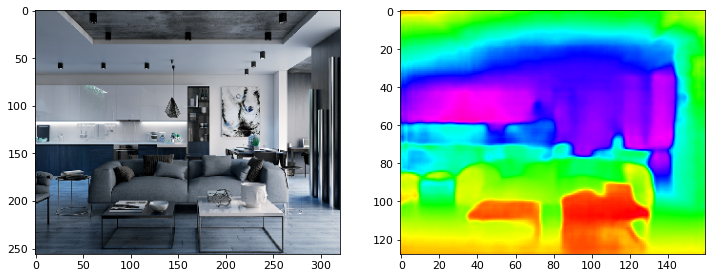

In [20]:
img = '/content/drive/MyDrive/DL_Project/in_images/indoor.jpg'
#img = images[11]
img_array = cv2.imread(img)
#img_array = img
OBJECTS = model_OD(img)
df_OD = OBJECTS.pandas().xyxy[0]
OBJECTS.save(save_dir='/content/drive/MyDrive/')
orig , pred = predict_img(img_array)

In [27]:
DEPTHS=[]
for index, row in df_OD.iterrows():
  object_depth = DEPTH_Calc(row['xmin'],row['ymin'],row['xmax'],row['ymax'])
  DEPTHS.append(round(object_depth,2))

df_OD['depth'] = DEPTHS
df_OD

# df_OD.sort_values('depth' , ascending= False)

,xmin,ymin,xmax,ymax,confidence,class,name,depth
0,1102.964478,416.092712,1234.176636,566.671021,0.839130,56,chair,4.92
1,350.451843,409.039093,890.171387,559.175476,0.773058,57,couch,3.86
2,509.859924,544.446228,563.990845,578.106628,0.714041,45,bowl,2.49
3,25.277760,448.807495,232.285339,656.254028,0.696508,56,chair,3.92
4,400.036469,545.248474,491.681030,573.408875,0.569688,73,book,2.38
5,789.993591,353.533539,824.314575,393.903351,0.493485,58,potted plant,7.22
6,1.719791,50.076191,172.024857,537.172119,0.443729,58,potted plant,5.60
7,790.558838,355.877594,823.830872,395.173248,0.265084,75,vase,7.20


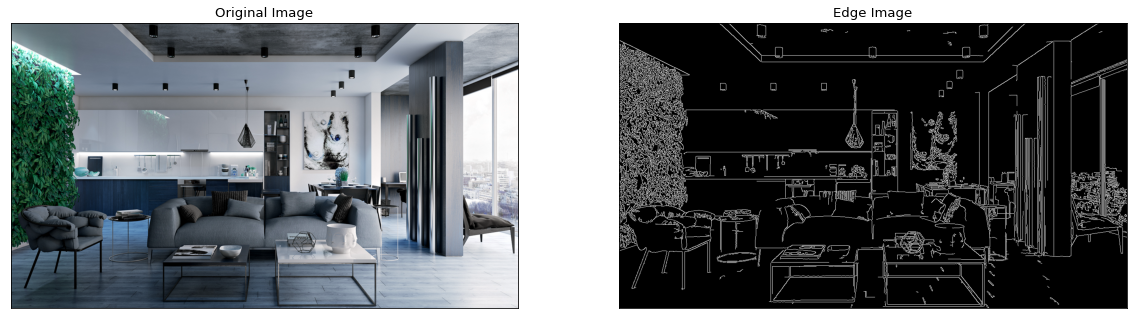

In [28]:
plt.figure(figsize =( 20, 12 ))
edges = cv2.Canny(img_array,100,200)
plt.subplot(121),plt.imshow(img_array,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [29]:
numOfClasses = np.unique(df_OD['name'])

In [30]:
cols = get_colors_for_classes(len(numOfClasses))

In [31]:
color_dict = {}
j = 0
for i in df_OD['name']:
  if i in color_dict.keys():
    continue
  color_dict [str(i)] = cols[j]
  j+=1

In [32]:
def segment_region(pixel_vals , shp):

  k = 2
  retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

  # convert data into 8-bit values
  centers = np.uint8(centers)
  segmented_data = centers[labels.flatten()]

  # reshape data into the original image dimensions
  segmented_image = segmented_data.reshape(shp)
  # plt.figure(figsize = (5,5))
  # plt.imshow(segmented_image)
  norm2 = np.linalg.norm (centers  - np.mean(segmented_image,  axis =(0,1) )   , axis = 1) 
  # print(np.argmin(norm2))
  # print(np.mean(segmented_image,  axis =(0,1) ) )
  return np.argmin(norm2) , centers , segmented_image
  

In [46]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
masked_image = np.copy(img_array)
winners = []
for index, row in df_OD.iterrows():
  cv2.rectangle(img_array, ( round(row['xmin']),round(row['ymin']) ), ( round(row['xmax']), round(row['ymax']) ), color_dict[row['name']],2) # add rectangle to image
  range_ =img_array [  round(row['ymin']) : round(row['ymax']) ,  round( row['xmin']):round(row['xmax']), : ]
  pixel_vals = range_.reshape((-1,3))
  pixel_vals = np.float32(pixel_vals)
  winner , centers , segmented = segment_region(pixel_vals ,  range_.shape)
  masked_image [  round(row['ymin']) : round(row['ymax']) ,  round( row['xmin']):round(row['xmax']), : ] = segmented
  winners.append( centers[winner]) 

df_OD['dominantPixel'] = winners


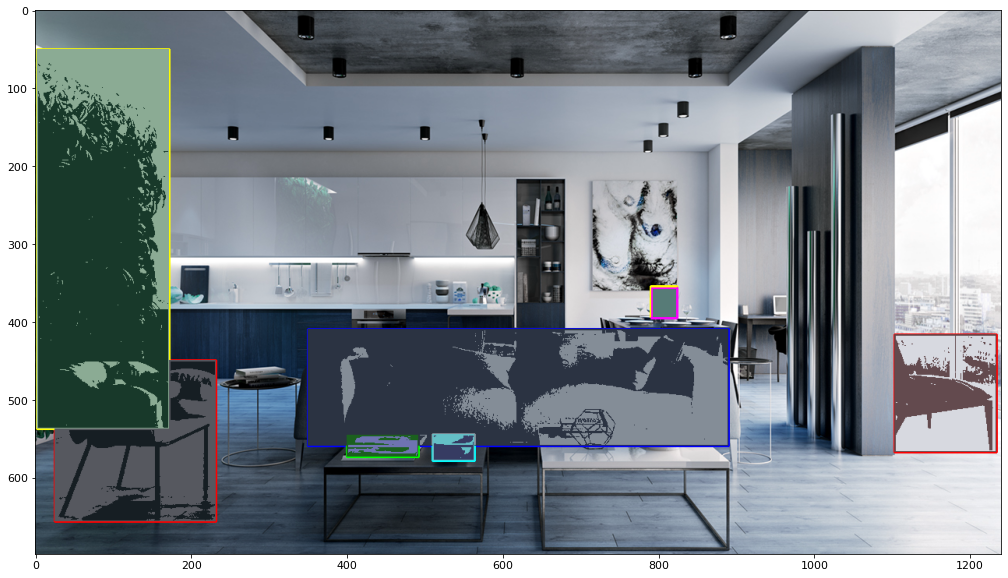

In [47]:
plt.figure(figsize = (20 , 10))
plt.imshow(masked_image)

In [73]:
DEPTHS=[]
for index, row in df_OD.iterrows():
  
  object_depth = DEPTH_Calc_masked(row['xmin'],row['ymin'],row['xmax'],row['ymax'] , row['dominantPixel'])
  DEPTHS.append(round(object_depth,2))

df_OD['depth'] = DEPTHS
df_OD

# df_OD.sort_values('depth' , ascending= False)

no pixels


,xmin,ymin,xmax,ymax,confidence,class,name,depth,dominantPixel
0,1102.964478,416.092712,1234.176636,566.671021,0.839130,56,chair,4.85,"[215, 217, 224]"
1,350.451843,409.039093,890.171387,559.175476,0.773058,57,couch,4.13,"[43, 51, 66]"
2,509.859924,544.446228,563.990845,578.106628,0.714041,45,bowl,2.41,"[54, 59, 98]"
3,25.277760,448.807495,232.285339,656.254028,0.696508,56,chair,3.71,"[86, 88, 95]"
4,400.036469,545.248474,491.681030,573.408875,0.569688,73,book,2.41,"[27, 96, 30]"
5,789.993591,353.533539,824.314575,393.903351,0.493485,58,potted plant,7.22,"[97, 109, 134]"
6,1.719791,50.076191,172.024857,537.172119,0.443729,58,potted plant,5.79,"[24, 57, 42]"
7,790.558838,355.877594,823.830872,395.173248,0.265084,75,vase,7.21,"[87, 123, 119]"


(-0.5, 1239.5, 697.5, -0.5)

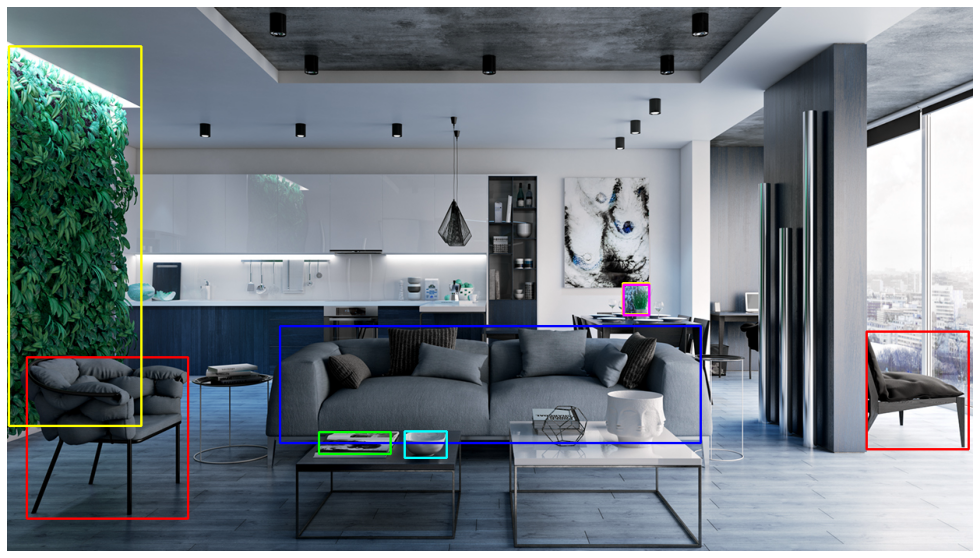

In [195]:

plt.figure(figsize = (20 , 10))
plt.imshow(img_array)
plt.axis ('off')

In [31]:
image, image_data = preprocess_image(img, model_image_size = (608, 608))
class_names = read_classes("/content/drive/MyDrive/DL_Project/coco_classes.txt")
colors = get_colors_for_classes(len(class_names))
out_boxes = np.zeros((len(df_OD.index),4))
out_classes=np.zeros((len(df_OD.index)))
out_scores = np.zeros((len(df_OD.index)))
for index, row in df_OD.iterrows():
  out_boxes[index,:]=[row['ymin'],row['xmin'],row['ymax'],row['xmax']]
  out_classes[index]=row['class']
  out_scores[index]=row['confidence']

o2= tf.convert_to_tensor(out_boxes)
o3= tf.convert_to_tensor(out_classes,dtype=tf.int32)
o5= tf.convert_to_tensor(out_scores)
draw_boxes(image, o2, o3, class_names, o5, DEPTHS)
image.save(os.path.join("/content/drive/MyDrive/DL_Project/out_images",'jadid.jpg'), quality=200)

(-0.5, 1239.5, 697.5, -0.5)

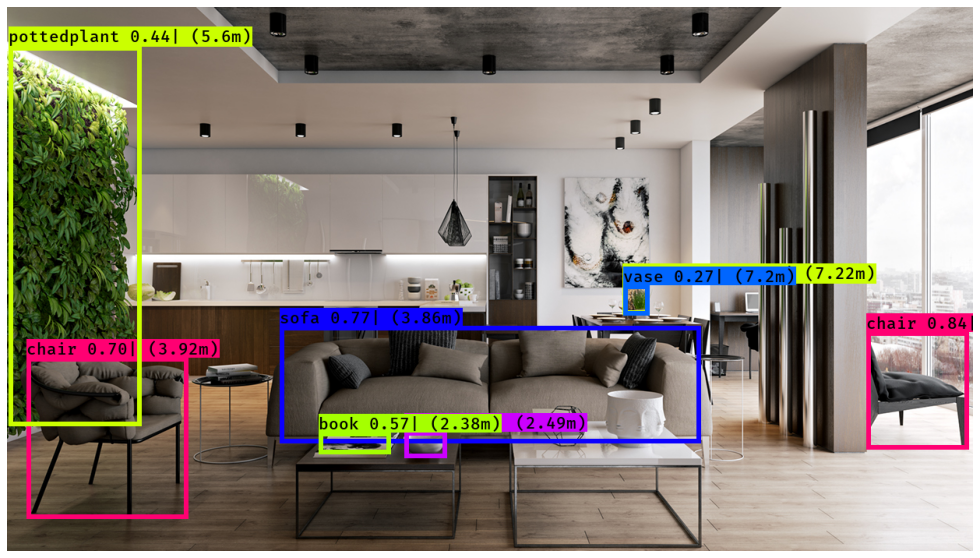

In [32]:
plt.figure( figsize = (20,10))
plt.imshow(image)
plt.axis ('off')